### Loading Libraries & Data

In [1]:
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import  corpus_bleu

from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Embedding, Bidirectional, GRU, TimeDistributed, RepeatVector, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy


In [2]:
import random
# load the text from the file
with open("english_corpus.txt", "r", encoding="utf-8") as file:
    english_sentences = file.readlines()

with open("urdu_corpus.txt", "r", encoding="utf-8") as file:
    urdu_sentences = file.readlines()

# print the number of sentences in each file
print("Number of English sentences:", len(english_sentences))
print("Number of Urdu sentences:", len(urdu_sentences))

# print some random english sentence and its corresponding urdu sentence
random_index = random.randint(0, len(english_sentences) - 1)

# print the random English sentence and its corresponding Urdu sentence
print("Random English sentence:", english_sentences[random_index])
print("Corresponding Urdu sentence:", urdu_sentences[random_index])

    



Number of English sentences: 24456
Number of Urdu sentences: 24456
Random English sentence: they are afraid of us

Corresponding Urdu sentence: وہ ہم سے ڈرتے ہیں



### Data Preprocessing

In [3]:
def tokenize(x):
    tokenizer = Tokenizer(oov_token='<OOV>')
    tokenizer.fit_on_texts(x)

    print(len(tokenizer.word_index))
    return tokenizer.texts_to_sequences(x), tokenizer



In [4]:
# tokenize urdu and english sentences
print("Tokenizing english sentences...")
english_sentences_tokenized, english_tokenizer = tokenize(english_sentences)
print("Tokenizing urdu sentences...")
urdu_sentences_tokenized, urdu_tokenizer = tokenize(urdu_sentences)


Tokenizing english sentences...
5661
Tokenizing urdu sentences...
5760


In [5]:
# find max lenrth of english and urdu sentences
english_max_length = max([len(sentence) for sentence in english_sentences_tokenized])
urdu_max_length = max([len(sentence) for sentence in urdu_sentences_tokenized])
print("Max length of english sentences:", english_max_length)
print("Max length of urdu sentences:", urdu_max_length)

Max length of english sentences: 14
Max length of urdu sentences: 19


In [6]:
# vocab size of english and urdu
english_vocab_size = len(english_tokenizer.word_index)
urdu_vocab_size = len(urdu_tokenizer.word_index)
print("English vocab size:", english_vocab_size)
print("Urdu vocab size:", urdu_vocab_size)

English vocab size: 5661
Urdu vocab size: 5760


In [7]:
# pad english and urdu sentences to 20 as max length
def pad(x, length=20):
    return pad_sequences(x, maxlen=length, padding='post')

In [8]:
# pad english and urdu sentences]
print("Padding english sentences...")
english_sentences_padded = pad(english_sentences_tokenized, english_max_length)
print("Padding urdu sentences...")
urdu_sentences_padded = pad(urdu_sentences_tokenized, urdu_max_length)

print("English sentences before padding:")
print(english_sentences_tokenized[0])
print("English sentences after padding:")
print(english_sentences_padded[0])
print("Urdu sentences before padding:")
print(urdu_sentences_tokenized[0])
print("Urdu sentences after padding:")
print(urdu_sentences_padded[0])



Padding english sentences...
Padding urdu sentences...
English sentences before padding:
[3, 5, 23, 2334]
English sentences after padding:
[   3    5   23 2334    0    0    0    0    0    0    0    0    0    0]
Urdu sentences before padding:
[4, 347, 2565, 11]
Urdu sentences after padding:
[   4  347 2565   11    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]


In [9]:
random_seed = 40

# create training and validation sets
# data split 80 10 10
def split_data(eng_sentences, y, test_size=0.2, val_size=0.5, random_state=random_seed):
    # split the dataset into training and temporary validation and test sets 80 - 20 %
    X_train, X_temp, y_train, y_temp = train_test_split(eng_sentences, y, test_size=test_size, random_state=random_state)

    # split the temporary set into validation and test sets 50 50 %
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_size, random_state=random_state)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


# create training, validation, and test sets
print("Creating training, validation, and test sets...")
(train_input, train_output), (val_input, val_output), (test_input, test_output) = split_data(english_sentences_padded, urdu_sentences_padded)

# print the shapes of the training, validation, and test sets
print("Train input shape:", train_input.shape)
print("Train output shape:", train_output.shape)
print("Validation input shape:", val_input.shape)
print("Validation output shape:", val_output.shape)
print("Test input shape:", test_input.shape)
print("Test output shape:", test_output.shape)



Creating training, validation, and test sets...
Train input shape: (19564, 14)
Train output shape: (19564, 19)
Validation input shape: (2446, 14)
Validation output shape: (2446, 19)
Test input shape: (2446, 14)
Test output shape: (2446, 19)


### Model Implementation

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.layers import Attention
import tensorflow as tf

def create_translation_model(max_len_eng, max_len_urdu, vocab_size_eng, vocab_size_urdu):
    embedding_dim = 256
    hidden_units = 32

    # text encoder mode    
    encoder_inputs = Input(shape=(max_len_eng,))

    # encoder embedding
    encoder_embedding = Embedding(input_dim=vocab_size_eng, output_dim=embedding_dim)(encoder_inputs)
    encoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
    
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
    # keep the states.
    encoder_states = [state_h, state_c]

    # decoder
    decoder_inputs = Input(shape=(max_len_urdu,))
    decoder_embedding = Embedding(input_dim=vocab_size_urdu, output_dim=embedding_dim)(decoder_inputs)
    decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

    # applying attention
    attention_layer = Attention()
    attention_result = attention_layer([decoder_outputs, encoder_outputs])
    decoder_combined_context = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs, attention_result])

    # prediction layer
    decoder_dense = TimeDistributed(Dense(vocab_size_urdu, activation='softmax'))
    output = decoder_dense(decoder_combined_context)

    # build the model
    model = Model([encoder_inputs, decoder_inputs], output)

    # compile the model
    learning_rate = 0.001
    model.compile(optimizer=Adam(learning_rate), loss=sparse_categorical_crossentropy, metrics=['accuracy'])

    return model




In [11]:
translation_model = create_translation_model(english_max_length, urdu_max_length, english_vocab_size+1, urdu_vocab_size+1)
translation_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 14)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 19)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 14, 256)              1449472   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 19, 256)              1474816   ['input_2[0][0]']             
                                                                                              

In [12]:
model_save_path = 'best_model.h5'

### Training

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

# save best model


# create checkpoint callback
checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

num_epochs = 64
batch_size = 64

# fit the model with the callback
history = translation_model.fit(
    [train_input, train_output], 
    train_output,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=([val_input, val_output], val_output),
    callbacks=[checkpoint]
)


Epoch 1/64
306/306 [==============================] - ETA: 0s - loss: 2.5484 - accuracy: 0.7424
Epoch 1: val_accuracy improved from -inf to 0.75640, saving model to best_model.h5
306/306 [==============================] - 33s 98ms/step - loss: 2.5484 - accuracy: 0.7424 - val_loss: 1.4597 - val_accuracy: 0.7564
Epoch 2/64
  1/306 [..............................] - ETA: 31s - loss: 1.4248 - accuracy: 0.7590

C:\Users\mujtaba\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


306/306 [==============================] - ETA: 0s - loss: 1.2957 - accuracy: 0.7764
Epoch 2: val_accuracy improved from 0.75640 to 0.79929, saving model to best_model.h5
306/306 [==============================] - 30s 97ms/step - loss: 1.2957 - accuracy: 0.7764 - val_loss: 1.1774 - val_accuracy: 0.7993
Epoch 3/64
306/306 [==============================] - ETA: 0s - loss: 1.0422 - accuracy: 0.8275
Epoch 3: val_accuracy improved from 0.79929 to 0.84998, saving model to best_model.h5
306/306 [==============================] - 29s 96ms/step - loss: 1.0422 - accuracy: 0.8275 - val_loss: 0.9563 - val_accuracy: 0.8500
Epoch 4/64
306/306 [==============================] - ETA: 0s - loss: 0.8318 - accuracy: 0.8712
Epoch 4: val_accuracy improved from 0.84998 to 0.88839, saving model to best_model.h5
306/306 [==============================] - 30s 97ms/step - loss: 0.8318 - accuracy: 0.8712 - val_loss: 0.7691 - val_accuracy: 0.8884
Epoch 5/64
306/306 [==============================] - ETA: 0s - lo

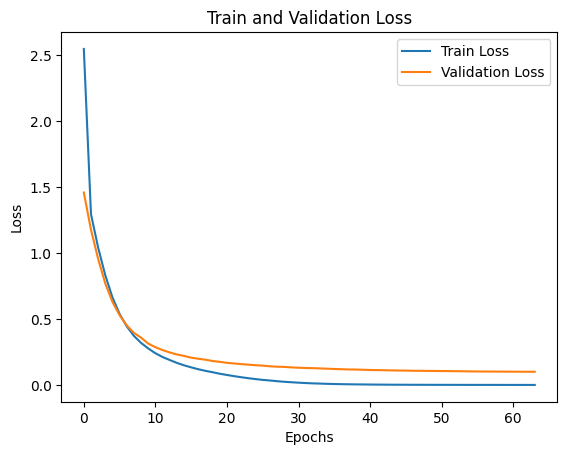

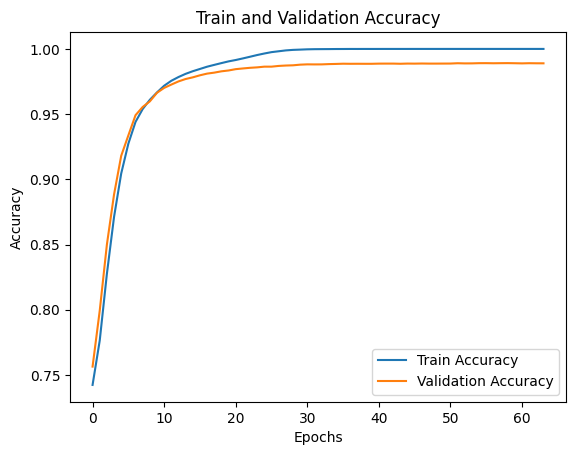

In [17]:
import matplotlib.pyplot as plt

# Plot the loss curves
plt.plot(translation_model.history.history['loss'], label='Train Loss')
plt.plot(translation_model.history.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.plot(translation_model.history.history['accuracy'], label='Train Accuracy')
plt.plot(translation_model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Evaluation

In [13]:
# load the best model
translation_model.load_weights(model_save_path)


In [14]:
import numpy as np

def convert_indices_to_text(input_sequences, word_indexer):
    text_sentences = []
    # text sentences from the input sequences
    for seq in input_sequences:
        # convert the indices to words
        words = [word_indexer.index_word.get(int(index), '<OOV>') for index in seq if word_indexer.index_word.get(int(index), '<OOV>') != '<OOV>']
        sentence = ' '.join(words)
        # append the sentence to the list
        text_sentences.append(sentence)
    return text_sentences

def translate_prediction_to_text(predicted_data, word_mapping):
    translated_sentences = []
    # get the indices of the maximum values in the numpy array
    prediction_indices = np.argmax(predicted_data, axis=-1)
    for idx_sequence in prediction_indices:
        # convert the indices to words
        translated_sequence = ' '.join([word_mapping.index_word.get(idx, '<OOV>') for idx in idx_sequence if word_mapping.index_word.get(idx, '<OOV>') != '<OOV>'])
        translated_sentences.append(translated_sequence)
    return translated_sentences

In [15]:
def evaluate_translation_performance(translation_model, train_input, train_output, val_input, val_output, test_input, test_output, english_sentences, urdu_sentences, sample_size=32*77):
    

    # initialize tokenizers
    tokenizer_eng = Tokenizer(oov_token="<OOV>")
    tokenizer_urdu = Tokenizer(oov_token="<OOV>")

    # fit tokenizers on respective texts
    tokenizer_eng.fit_on_texts(english_sentences)
    tokenizer_urdu.fit_on_texts(urdu_sentences)
    


    #  function to perform predictions and calculate bleu scores
    def predict_and_evaluate(input_data, output_data):
        # predict using the model
        predictions = translation_model.predict([input_data, output_data])
        # convert the predictions to text
        pred_decoded = translate_prediction_to_text(predictions, tokenizer_urdu)
        # convert the actual output to text
        y_decoded = convert_indices_to_text(output_data, tokenizer_urdu)
        # calculate the bleu scores
        overall_bleu_score = corpus_bleu([[ref] for ref in y_decoded], pred_decoded)
        # calculate the n-gram bleu scores
        ngram_bleu_scores = [corpus_bleu([[ref] for ref in y_decoded], pred_decoded, weights=((1.0 / n, ) + (0, ) * (3 - n))) for n in range(1, 5)]
        return overall_bleu_score, ngram_bleu_scores

    # run on training, validation, and test datasets
    train_bleu_scores = predict_and_evaluate(train_input[:sample_size], train_output[:sample_size])
    val_bleu_scores = predict_and_evaluate(val_input, val_output)
    test_bleu_scores = predict_and_evaluate(test_input, test_output)

    return {
        'training': train_bleu_scores,
        'validation': val_bleu_scores,
        'testing': test_bleu_scores
    }




In [18]:
def print_bleu_scores(dataset_name, bleu_scores):
    # unpack the bleu scores
    overall_bleu, ngram_bleus = bleu_scores
    # print the bleu scores
    print(f"{dataset_name} BLEU Scores")
    print(f"  - Cumulative: {overall_bleu}")
    for i, score in enumerate(ngram_bleus, start=1):
        print(f"  - {i}-gram: {score}")
    print("\n")

results = evaluate_translation_performance(translation_model, train_input, train_output, val_input, val_output, test_input, test_output, english_sentences, urdu_sentences)

print_bleu_scores("Training", results['training'])
print_bleu_scores("Validation", results['validation'])
print_bleu_scores("Testing", results['testing'])


77/77 [==============================] - 1s 9ms/step
Training BLEU Scores
  - Cumulative: 0.999988450055149
  - 1-gram: 1.0
  - 2-gram: 1.0
  - 3-gram: 1.0
  - 4-gram: 1.0


Validation BLEU Scores
  - Cumulative: 0.9395003210507176
  - 1-gram: 0.9607358267617421
  - 2-gram: 0.976570276537545
  - 3-gram: 0.9819062103515668
  - 4-gram: 0.9845851005562464


Testing BLEU Scores
  - Cumulative: 0.9530864284829903
  - 1-gram: 0.9697005386286498
  - 2-gram: 0.982752890659167
  - 3-gram: 0.9871426001221871
  - 4-gram: 0.9893448022860827




### Result Visualization

In [17]:
def display_translation_examples(translation_model, test_input_data, test_output_data, tokenizer_source, tokenizer_target, source_sentences, num_examples=50):
    # predict using the model
    predictions = translation_model.predict([test_input_data, test_output_data])
    # convert the predictions to text
    pred_decoded = translate_prediction_to_text(predictions, tokenizer_target)
    y_decoded = convert_indices_to_text(test_output_data, tokenizer_target)
    for i in range(min(num_examples, len(test_input_data))):
        # convert the input sequence to text
        input_sequence = ''.join(convert_indices_to_text([test_input_data[i]], tokenizer_source)[0])
        original_translation = ''.join(y_decoded[i]) # convert the actual output to text
        predicted_translation = ''.join(pred_decoded[i]) # convert the predicted sequence to text
        print(f"Input Sentence: {input_sequence}") # print the input sequence
        print(f"Actual Translation: {original_translation}")
        print(f"Predicted Translation: {predicted_translation}")
        print("\n")     

# display some examples
tokenizer_urdu = Tokenizer(oov_token="<OOV>")
tokenizer_urdu.fit_on_texts(urdu_sentences)
tokenizer_eng = Tokenizer(oov_token="<OOV>")
tokenizer_eng.fit_on_texts(english_sentences)
display_translation_examples(translation_model, test_input, test_output, tokenizer_eng, tokenizer_urdu, english_sentences)


77/77 [==============================] - 1s 10ms/step
Input Sentence: you promised to help
Actual Translation: آپ نے مدد کرنے کا وعدہ کیا۔
Predicted Translation: آپ نے مدد کرنے کا وعدہ کیا۔


Input Sentence: i know you know this
Actual Translation: میں جانتا ہوں تم یہ جانتے ہو۔
Predicted Translation: میں جانتا ہوں تم یہ جانتے ہو۔


Input Sentence: is that the plan
Actual Translation: کیا یہ منصوبہ ہے
Predicted Translation: کیا یہ منصوبہ ہے


Input Sentence: i just want your love
Actual Translation: میں صرف آپ کی محبت چاہتے ہیں
Predicted Translation: میں صرف آپ کی محبت چاہتے ہیں


Input Sentence: can i sit with you
Actual Translation: کیا میں آپ کے ساتھ بیٹھ سکتا ہوں؟
Predicted Translation: کیا میں آپ کے ساتھ بیٹھ سکتا ہوں؟


Input Sentence: dont push your luck
Actual Translation: اپنی قسمت کو دھکا نہ دیں
Predicted Translation: اپنی قسمت کو دھکا نہ دیں


Input Sentence: zain couldnt talk
Actual Translation: زین بات نہیں کر سکتا تھا
Predicted Translation: زین بات نہیں کر سکتا تھا


Input